## Target Maximization

This section covers budget optimization by maximizing target with the insights from a fitted MMM.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning.optim import TargetMaximizer
from karpiu.planning.common import generate_cost_report

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [7]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [8]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05736,0.04121,0.07378,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.05506,0.03968,0.06886,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20909,0.18660,0.23081,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.07827,0.05903,0.09767,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.10681,0.08683,0.12805,1.00000,0.00000,0.00000,0.10000


In [9]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

In [53]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=1e-3,
)
optim_spend_df = maximizer.optimize(maxiter=1000)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -7318.007240550194
            Iterations: 48
            Function evaluations: 7387
            Gradient evaluations: 47


In [55]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [57]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 490508
Total Budget: 490508


### Budget Allocation

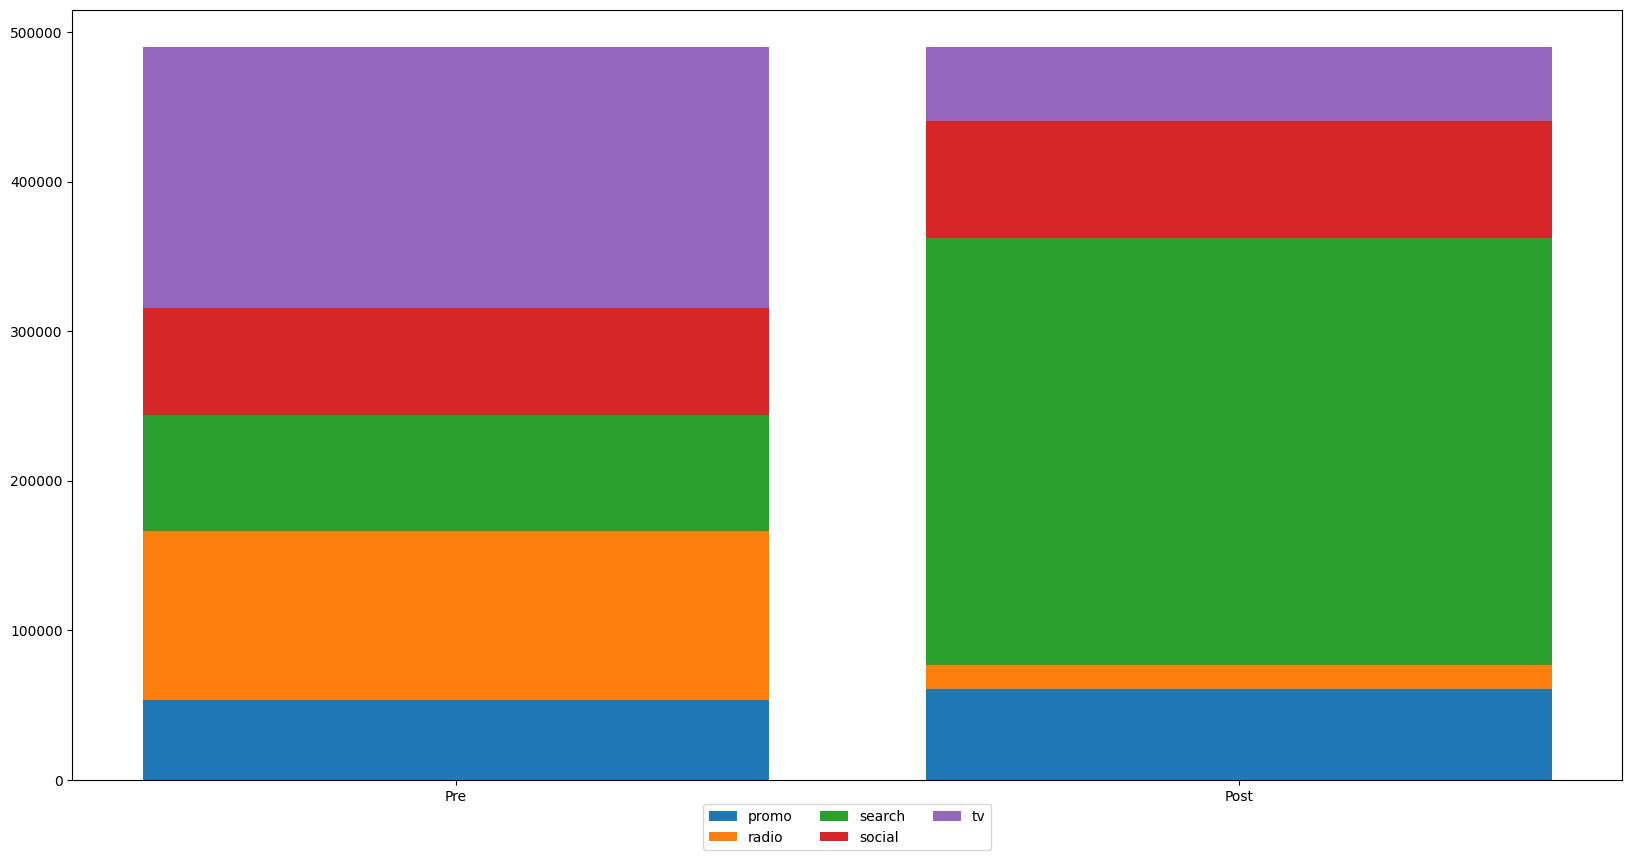

In [50]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [51]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,38.86283,39.93671,43.32483,42.65862,53.30000,60.98161
radio,79.55461,40.72423,87.02984,44.36556,112.97900,15.91539
search,21.24898,39.77957,24.43860,42.53222,78.03300,285.73537
social,40.12583,40.94202,41.21572,42.70819,71.64400,77.93545
tv,65.72122,40.55574,72.08270,44.12223,174.55200,49.94018


### Outcome Plot

In [59]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

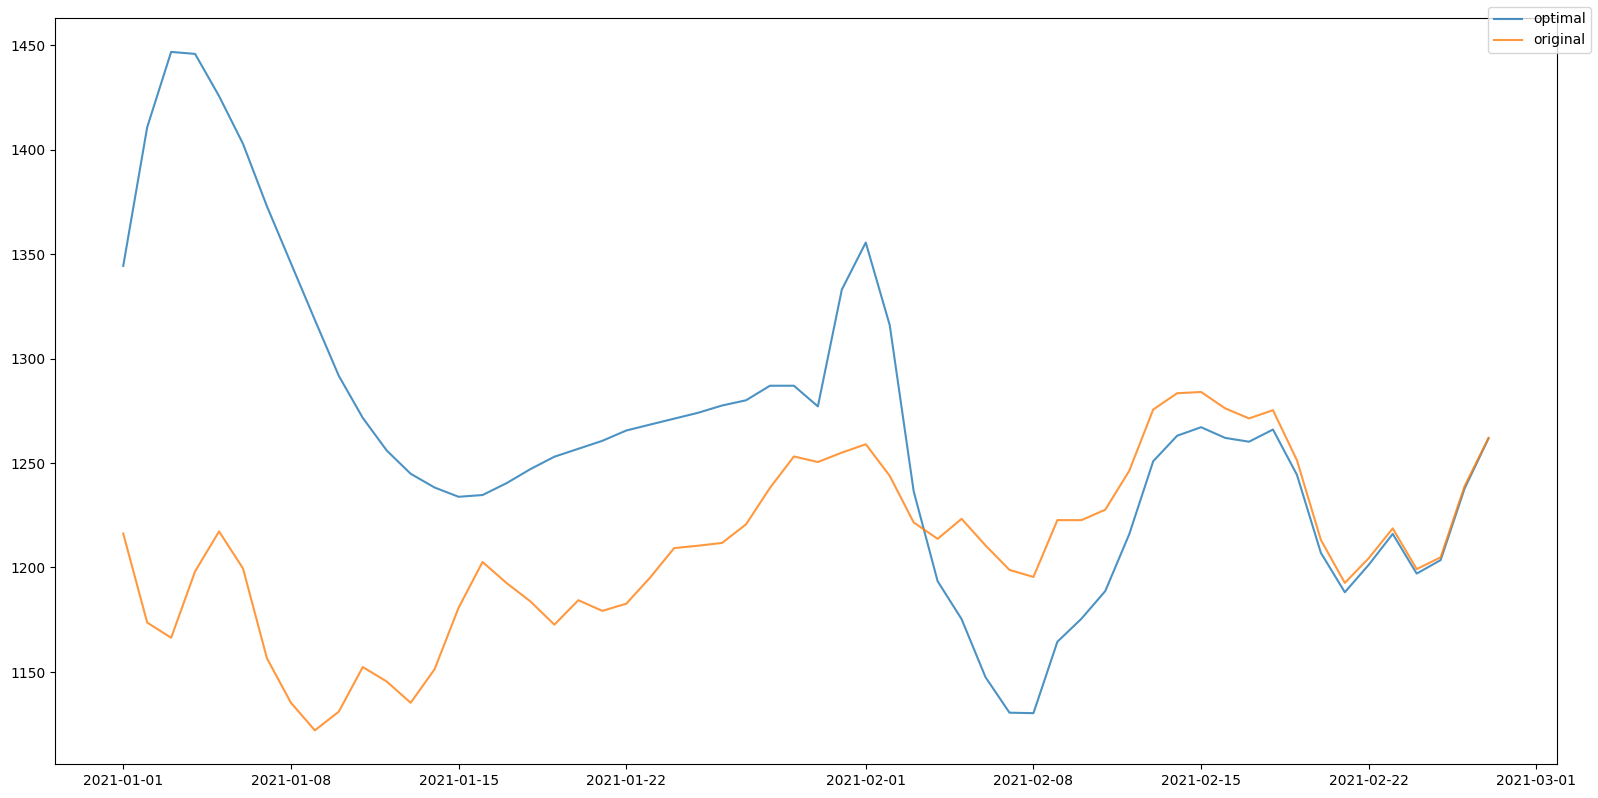

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    optim_pred.loc[maximizer.result_mask, "date"].values,
    optim_pred.loc[maximizer.result_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[maximizer.result_mask, "date"].values,
    init_pred.loc[maximizer.result_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [63]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[maximizer.result_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[maximizer.result_mask, "prediction"].values)
assert total_optim_pred > total_init_pred

Right now change the raw_df in a hacky way inside the mmm model so that it has different initial spend.
then
1. change spend but preserve total in the period
2. plug back into new model object
3. create new optim object
4. check result

In [3]:
import pytest
import numpy as np
import pandas as pd
from copy import deepcopy

from karpiu.models import MMM
from karpiu.simulation import make_mmm_daily_data
from karpiu.planning.optim import TargetMaximizer
from karpiu.planning.common import generate_cost_report
from karpiu.utils import adstock_process

In [4]:
# data_args
seed = 2022
n_steps = 365 * 3
channels_coef = [0.053, 0.08, 0.19, 0.125, 0.1]
channels = ["promo", "radio", "search", "social", "tv"]
features_loc = np.array([2000, 5000, 3850, 3000, 7500])
features_scale = np.array([550, 2500, 500, 1000, 3500])
scalability = np.array([3.0, 1.25, 0.8, 1.3, 1.5])
start_date = "2019-01-01"
# adstock_args = {
#     "n_steps": 28,
#     "peak_step": np.array([10, 8, 5, 3, 2]),
#     "left_growth": np.array([0.05, 0.08, 0.1, 0.5, 0.75]),
#     "right_growth": np.array([-0.03, -0.6, -0.5, -0.1, -0.25]),
# }
best_params = {
    "damped_factor": 0.9057,
    "level_sm_input": 0.00245,
}
np.random.seed(seed)

df, scalability_df, adstock_df, event_cols = make_mmm_daily_data(
    channels_coef=channels_coef,
    channels=channels,
    features_loc=features_loc,
    features_scale=features_scale,
    scalability=scalability,
    n_steps=n_steps,
    start_date=start_date,
    adstock_args=None,
    with_yearly_seasonality=True,
    with_weekly_seasonality=True,
    country="US",
)

mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=channels,
    event_cols=event_cols,
    seed=seed,
    adstock_df=adstock_df,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
)
mmm.derive_saturation(df=df, scalability_df=scalability_df)
mmm.set_hyper_params(params=best_params)
# need this 4000/4000 to make sure coefficients are converged
mmm.fit(df, num_warmup=1000, num_sample=1000, chains=4)
budget_start = "2020-01-01"
budget_end = "2020-01-31"
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

2023-03-28 23:11:52 - karpiu-mmm - INFO - Initialize model
2023-03-28 23:11:52 - karpiu-mmm - INFO - Deriving saturation constants...
2023-03-28 23:11:52 - karpiu-mmm - INFO - Derived saturation constants.
2023-03-28 23:11:52 - karpiu-mmm - INFO - Set hyper-parameters.
2023-03-28 23:11:52 - karpiu-mmm - INFO - Best params damped_factor set as 0.90570
2023-03-28 23:11:52 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245
2023-03-28 23:11:52 - karpiu-mmm - INFO - Fit final model.
2023-03-28 23:11:52 - karpiu-mmm - INFO - Build a default regression scheme
2023-03-28 23:11:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-03-28 23:14:03 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.512506) is within common range (0, 0.8].


Optimization terminated successfully    (Exit mode 0)
            Current function value: -49085.96555826407
            Iterations: 949
            Function evaluations: 148045
            Gradient evaluations: 949


AssertionError: 

In [123]:
df

,date,sales,promo,radio,search,social,tv,new-years-day,martin-luther-king-jr-day,washingtons-birthday,...,labor-day,columbus-day,veterans-day,thanksgiving,christmas-day,independence-day-observed,juneteenth-national-independence-day-observed,juneteenth-national-independence-day,christmas-day-observed,new-years-day-observed
0,2019-01-01,1401.00000,0.00000,5248.00000,3591.00000,0.00000,3454.00000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-02,906.00000,0.00000,3360.00000,3598.00000,3087.00000,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-03,930.00000,2891.00000,10145.00000,4184.00000,2595.00000,12127.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-04,728.00000,1579.00000,5853.00000,3704.00000,0.00000,4570.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-05,653.00000,996.00000,6580.00000,4403.00000,3383.00000,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2021-12-26,1353.00000,0.00000,7836.00000,4091.00000,0.00000,3450.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1091,2021-12-27,2522.00000,0.00000,4024.00000,3644.00000,2269.00000,10284.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1092,2021-12-28,1909.00000,2407.00000,0.00000,0.00000,2611.00000,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1093,2021-12-29,1804.00000,2472.00000,625.00000,4394.00000,3041.00000,3840.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=0.0,
    spend_scaler=1.0,
    response_scaler=0.01 * np.std(df["sales"].values),
)
optim_spend_df = maximizer.optimize(maxiter=3000, ftol=1e-3)

optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()
# always spend all budget in target maximization; assure the total preserves
assert np.allclose(np.sum(optim_spend_matrix), np.sum(init_spend_matrix))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -10997.260528110632
            Iterations: 126
            Function evaluations: 19668
            Gradient evaluations: 126


In [195]:
init_spend_matrix.sum()

545762.0

In [196]:
optim_spend_matrix.sum()

545762.00001

In [197]:
mmm.get_max_adstock()

0

In [198]:
optim_spend_matrix

array([[ 1936.54268,  2006.54843,  4846.21522, 17158.99012,  3992.58292],
       [  404.09251,  1778.31528,  8924.46959,  1033.00617,     4.22092],
       [  287.7425 ,  2084.89271,  8164.12797,  1046.17782,     0.     ],
       [  719.52849,     0.     ,  1966.004  ,  1279.26669,   245.08629],
       [ 2602.655  ,  3185.73355,  3207.70954, 11831.28034, 10736.91044],
       [ 3296.08775,  1900.60822,  7558.90514,  5686.70711,  3342.076  ],
       [ 3828.01312,  1961.06815,  7179.16502,  5541.53327,  7980.98676],
       [  163.04876,   243.1117 ,  2796.49592, 10526.62662,   187.55621],
       [    0.     ,  3534.4617 ,  2571.65743,  1956.54211,     1.1544 ],
       [ 2816.98138,  1391.04449,  2054.08073,  8600.70417,  3650.94968],
       [   94.43045,   492.06909,  8166.85959,  1025.99523,  4763.49367],
       [  315.5131 ,  3118.97378,  3070.58169,  2149.82514,     0.     ],
       [ 2384.76496,  1136.35193,  6000.11883, 20526.18516,  4145.66013],
       [ 7887.27831,  2381.00412,  613

In [192]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)

pre_opt_spend = cost_report["pre-opt-spend"].values
pre_ac = cost_report["pre-opt-avg-cost"].values[pre_opt_spend > 0]
pre_mc = cost_report["pre-opt-marginal-cost"].values[pre_opt_spend > 0]

post_opt_spend = cost_report["post-opt-spend"].values
post_ac = cost_report["post-opt-avg-cost"].values[post_opt_spend > 0]
post_mc = cost_report["post-opt-marginal-cost"].values[post_opt_spend > 0]

assert np.all(pre_mc >= pre_ac)
assert np.all(post_mc >= post_ac)

In [193]:
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,50.50007,47.25963,54.33316,55.72796,49.99200,97.81719
radio,74.28564,42.56076,110.02550,50.25699,129.35500,45.65746
search,28.11295,33.96344,36.37019,48.97609,95.57900,207.04465
social,31.72900,38.18070,40.35832,56.40111,74.09300,194.82602
tv,105.26451,50.78956,149.10676,52.43751,196.74300,32.19451


In [205]:
optim_spend_matrix

array([[ 1936.54268,  2006.54843,  4846.21522, 17158.99012,  3992.58292],
       [  404.09251,  1778.31528,  8924.46959,  1033.00617,     4.22092],
       [  287.7425 ,  2084.89271,  8164.12797,  1046.17782,     0.     ],
       [  719.52849,     0.     ,  1966.004  ,  1279.26669,   245.08629],
       [ 2602.655  ,  3185.73355,  3207.70954, 11831.28034, 10736.91044],
       [ 3296.08775,  1900.60822,  7558.90514,  5686.70711,  3342.076  ],
       [ 3828.01312,  1961.06815,  7179.16502,  5541.53327,  7980.98676],
       [  163.04876,   243.1117 ,  2796.49592, 10526.62662,   187.55621],
       [    0.     ,  3534.4617 ,  2571.65743,  1956.54211,     1.1544 ],
       [ 2816.98138,  1391.04449,  2054.08073,  8600.70417,  3650.94968],
       [   94.43045,   492.06909,  8166.85959,  1025.99523,  4763.49367],
       [  315.5131 ,  3118.97378,  3070.58169,  2149.82514,     0.     ],
       [ 2384.76496,  1136.35193,  6000.11883, 20526.18516,  4145.66013],
       [ 7887.27831,  2381.00412,  613

In [202]:
# check 2: all marginal cost of channel that has spend
# within 15% of mean
abs_delta_perc = np.abs(post_mc / np.nanmean(post_mc) - 1.00)
assert np.all(abs_delta_perc < 0.15)

cv = np.nanstd(post_mc) / np.nanmean(post_mc)
assert np.all(cv < 0.1)

# check 3: total predicted response must be equal to or higher than current
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)
total_optim_pred = np.sum(optim_pred.loc[maximizer.result_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[maximizer.result_mask, "prediction"].values)
assert total_optim_pred - total_init_pred >= 0

# check 4: optimization result should be indifferent with initial values
# create different initial spend df and plug back into the model
new_raw_df = mmm.get_raw_df()
new_spend_matrix = new_raw_df.loc[
    (new_raw_df["date"] >= budget_start) & (new_raw_df["date"] <= budget_end),
    optim_channels,
].values
# mutable numpy array
np.random.shuffle(new_spend_matrix)
new_raw_df.loc[
    (new_raw_df["date"] >= budget_start) & (new_raw_df["date"] <= budget_end),
    optim_channels,
] = new_spend_matrix
new_mmm = deepcopy(mmm)
new_mmm.raw_df = new_raw_df
new_maximizer = TargetMaximizer(
    model=new_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=0.0,
    spend_scaler=1.0,
    response_scaler=0.01 * np.std(df["sales"].values),
)
_ = new_maximizer.optimize(maxiter=3000, ftol=1e-3)
new_optim_spend_matrix = new_maximizer.get_current_state()
new_init_spend_matrix = new_maximizer.get_init_state()

# the final result should be closed in either by 1e-1 or .1%
assert np.any(np.not_equal(new_init_spend_matrix, init_spend_matrix))
# FIXME: this should not be 10% different; come back to this once we have a faster unit test
# right now, we turn off adstock make this work
assert np.allclose(new_optim_spend_matrix, optim_spend_matrix, atol=1e-1, rtol=1e-1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -10985.817762844608
            Iterations: 218
            Function evaluations: 34032
            Gradient evaluations: 218


AssertionError: 

In [114]:
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,50.50007,46.40325,54.33316,57.49524,49.99200,93.19271
radio,74.28564,39.98051,110.02550,47.37869,129.35500,26.80708
search,28.11295,35.16070,36.37019,52.96610,95.57900,221.92185
social,31.72900,36.78344,40.35832,55.31522,74.09300,183.15353
tv,105.26451,52.45526,149.10676,60.54855,196.74300,20.68684


In [179]:
assert np.allclose(new_optim_spend_matrix, optim_spend_matrix, atol=1e-1, rtol=1e-1)

AssertionError: 

In [206]:
new_optim_spend_matrix

array([[ 1815.9961 ,  5083.80513,  5016.21069,  5988.43659,  1401.28742],
       [ 1417.47279,    20.19917,  2086.5572 ,  2795.39508,     0.09185],
       [    0.4516 ,  1181.21914,  2759.06116,  1856.09101,  6220.60142],
       [ 2229.08492,   295.7384 ,  1270.38341,  6934.44696,  1746.59409],
       [  936.92985,  1010.05598,  2092.15974,  8958.06312,   155.5137 ],
       [ 5597.98246,   823.15538,  5632.6783 ,  5057.63769,  2728.29895],
       [ 3872.49532,  1267.82359,  6987.62339,  5661.41011,  1770.51996],
       [  725.4606 ,  3893.20238,  3638.44272,  2463.8922 ,  4690.94782],
       [ 1665.49572, 11739.4963 , 11168.23222,  1697.67732, 10289.28402],
       [  193.24392,  1629.12712,  1946.77492,  1393.42125,  2188.38038],
       [   10.36168,     0.     ,  1230.9514 ,   568.15718,     0.     ],
       [   83.89325,    53.73116, 12859.64527,  3541.16423,  6444.42347],
       [ 2606.09564,  1414.7864 ,  5505.59428, 18331.56076,  3110.52193],
       [ 2564.40131,   892.61252,  643

In [207]:
optim_spend_matrix

array([[ 1936.54268,  2006.54843,  4846.21522, 17158.99012,  3992.58292],
       [  404.09251,  1778.31528,  8924.46959,  1033.00617,     4.22092],
       [  287.7425 ,  2084.89271,  8164.12797,  1046.17782,     0.     ],
       [  719.52849,     0.     ,  1966.004  ,  1279.26669,   245.08629],
       [ 2602.655  ,  3185.73355,  3207.70954, 11831.28034, 10736.91044],
       [ 3296.08775,  1900.60822,  7558.90514,  5686.70711,  3342.076  ],
       [ 3828.01312,  1961.06815,  7179.16502,  5541.53327,  7980.98676],
       [  163.04876,   243.1117 ,  2796.49592, 10526.62662,   187.55621],
       [    0.     ,  3534.4617 ,  2571.65743,  1956.54211,     1.1544 ],
       [ 2816.98138,  1391.04449,  2054.08073,  8600.70417,  3650.94968],
       [   94.43045,   492.06909,  8166.85959,  1025.99523,  4763.49367],
       [  315.5131 ,  3118.97378,  3070.58169,  2149.82514,     0.     ],
       [ 2384.76496,  1136.35193,  6000.11883, 20526.18516,  4145.66013],
       [ 7887.27831,  2381.00412,  613